## DarkNet 

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive 
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!unzip "/gdrive/MyDrive/car.zip"

Archive:  /gdrive/MyDrive/car.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  
  inflating: data/testing_images/vid_5_26600.jpg  
  inflating: data/testing_images/vid_5_26620.jpg  
  inflating: data/testing_images/vid_5_26640.jpg  
  inflating: data/testing_images/vid_5_26660.jpg  
  infl

In [3]:
box = pd.read_csv('/content/data/train_solution_bounding_boxes (1).csv')
box.head(10)

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
5,vid_4_10100.jpg,447.568741,160.625804,582.083936,232.517696
6,vid_4_10120.jpg,168.755427,180.677284,304.738061,246.700450
7,vid_4_10140.jpg,0.000000,188.991313,85.111433,249.145753
8,vid_4_1020.jpg,202.506512,189.480373,239.192475,229.094273
9,vid_4_1040.jpg,116.416787,189.969434,180.494935,229.094273


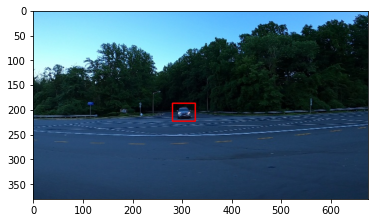

In [4]:
sample = cv2.imread('/content/data/training_images/vid_4_1000.jpg')
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
point = box.iloc[0]
pt1 = (int(point['xmin']), int(point['ymax']))
pt2 = (int(point['xmax']), int(point['ymin']))
cv2.rectangle(sample, pt1, pt2, color=(255,0,0), thickness=2)
plt.imshow(sample)

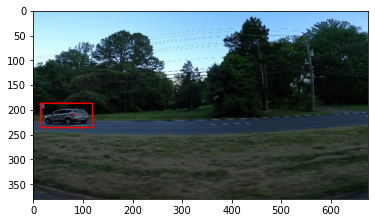

In [6]:
sample = cv2.imread('/content/data/training_images/vid_4_10000.jpg')
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
point = box.iloc[1]
pt1 = (int(point['xmin']), int(point['ymax']))
pt2 = (int(point['xmax']), int(point['ymin']))
cv2.rectangle(sample, pt1, pt2, color=(255,0,0), thickness=2)
plt.imshow(sample)

In [11]:
# YOLO WEIGHT, CFG Loading 
!wget https://pjreddie.com/media/files/yolov3.weights

--2022-08-22 09:59:22--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  40.6MB/s    in 6.3s    

2022-08-22 09:59:28 (37.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [9]:
!git clone https://github.com/pjreddie/darknet
!cd darknet
!make

fatal: destination path 'darknet' already exists and is not an empty directory.
make: *** No targets specified and no makefile found.  Stop.


In [25]:
# Yolo 로드
net = cv2.dnn.readNet("/content/yolov3.weights", "/content/darknet/cfg/yolov3.cfg")
classes = []
with open("/content/darknet/data/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [26]:
# 이미지 가져오기
img = cv2.imread('/content/data/training_images/vid_4_10000.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, channels = img.shape

In [27]:
blob = cv2.dnn.blobFromImage(img, 1/256, (416, 416), (0, 0, 0), swapRB=True, crop=False)
net.setInput(blob)

# outs는 출력으로 탐지된 개체에 대한 모든 정보와 위치를 제공한다.
outs = net.forward(output_layers)

In [28]:
# 정보를 화면에 표시
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # 좌표
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [29]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)


22 197 92 32


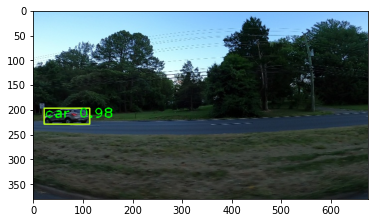

In [30]:
font = cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(0, 255, size=(len(boxes), 3))

for i in indices.flatten():
    x, y, w, h = boxes[i]
    print(x, y, w, h)
    label = str(classes[class_ids[i]])
    confidence = str(round(confidences[i], 2))
    color = colors[i]
    cv2.rectangle(img, (x, y), ((x+w), (y+h)), color, 2)
    cv2.putText(img, label + " " + confidence, (x, y+20), font, 2, (0, 255, 0), 2)

plt.imshow(img)

In [31]:
# Visualization Function
def predict_yolo(img_path):
  # 이미지 가져오기
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  height, width, channels = img.shape

  blob = cv2.dnn.blobFromImage(img, 1/256, (416, 416), (0, 0, 0), swapRB=True, crop=False)
  net.setInput(blob) 
  outs = net.forward(output_layers)

  class_ids = []
  confidences = []
  boxes = []
  for out in outs:
      for detection in out:
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]
          if confidence > 0.5:
              # Object detected
              center_x = int(detection[0] * width)
              center_y = int(detection[1] * height)
              w = int(detection[2] * width)
              h = int(detection[3] * height)
              # 좌표
              x = int(center_x - w / 2)
              y = int(center_y - h / 2)
              boxes.append([x, y, w, h])
              confidences.append(float(confidence))
              class_ids.append(class_id)

  indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

  font = cv2.FONT_HERSHEY_PLAIN
  colors = np.random.uniform(0, 255, size=(len(boxes), 3))
  if len(indexes) > 0:
    for i in indexes.flatten():
        x, y, w, h = boxes[i]
        print(x, y, w, h)
        label = str(classes[class_ids[i]])
        confidence = str(round(confidences[i], 2))
        color = colors[i]
        cv2.rectangle(img, (x, y), ((x+w), (y+h)), color, 2)
        cv2.putText(img, label + " " + confidence, (x, y+20), font, 2, (0, 255, 0), 2)

    plt.imshow(img)
  
  else:
    print('탐지된 물체가 없습니다.')

-1 208 100 32


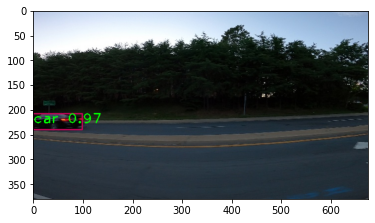

In [37]:
import glob
import random

paths = glob.glob('/content/data/testing_images/*.jpg')

img_path = random.choice(paths)

predict_yolo(img_path)